In [28]:
import pandas as pd
max_batch = 3
gpu_list = [1080, 2060]

def prune_df(df):
    trash_list = list()

    for i in range(len(df)):
        if df.iloc[i]['Op'] in ['__add__', '__iadd__']:
            trash_list.append(i)

    for i in trash_list:
        df.iloc[i-1]['duration'] += df.iloc[i]['duration']
    return df.drop(trash_list).reset_index()

class Model:
    def __init__(self, name, layer, movement):
        self.layer = layer
        self.movement = movement
        self.name = name

resnet_layer = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"Resnet/ResNet_{gpu}_{i}.csv"
        if not i in resnet_layer:
            resnet_layer[i] = dict()
        resnet_layer[i][gpu] = prune_df(pd.read_csv(filename))['duration']
resnet_movement = get_movement_time(get_all_shape(resnet18()))

ResNet = Model("ResNet", resnet_layer, resnet_movement)
        

alexnet_layer = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"AlexNet/ResNet_{gpu}_{i}.csv"
        if not i in alexnet_layer:
            alexnet_layer[i] = dict()
        alexnet_layer[i][gpu] = prune_df(pd.read_csv(filename))['duration']
alexnet_movement = get_movement_time(get_all_shape(alexnet()))
AlexNet = Model("AlexNet", alexnet_layer, alexnet_movement)

rnn_layer = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"rnn_result/rnn_{gpu}_{i}.csv"
        if not i in rnn_layer:
            rnn_layer[i] = dict()
        rnn_layer[i][gpu] = prune_df(pd.read_csv(filename))['duration']
rnn_shape = [torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 128])]
rnn_movement = get_movement_time(rnn_shape)
RNN = Model("RNN", rnn_layer, rnn_movement)

mobilenet_large_layer = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"mobile_large_result/Mobile_{gpu}_{i}.csv"
        if not i in mobilenet_large_layer:
            mobilenet_large_layer[i] = dict()
        mobilenet_large_layer[i][gpu] = prune_df(pd.read_csv(filename))['duration']
MobileNetLarge = Model("MobileNet Large", mobilenet_large_layer, mobilenet_large_movement)

# DLRM = dict()
# for i in range(1, max_batch + 1):
#     for gpu in gpu_list:
#         filename = f"dlrm_result/dlrm_{gpu}_{i}.csv"
#         if not i in DLRM:
#             DLRM[i] = dict()
#         DLRM[i][gpu] = prune_df(pd.read_csv(filename))['duration']

<ipython-input-28-f4234da8c7a7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i-1]['duration'] += df.iloc[i]['duration']


NameError: name 'mobilenet_large_movement' is not defined

In [3]:
from torchvision.models import resnet18, vgg16, alexnet
from time import sleep

def get_all_shape(model):
    children = get_children(model)
    all_input_shape = list()

    def make_forward(original_forward):
        def new_forward(x):
            all_input_shape.append(x.shape)
            out = original_forward(x)
            return out
        return new_forward

    for layer in children:
        original_forward = layer.forward

        layer.forward = make_forward(original_forward)

    data = torch.randn(1, 3, 224, 224)
    result = model(data)
    return all_input_shape
    
def get_movement_time(all_input_shape):
    
    movement_time = list()

    for shape in all_input_shape:
        sleep(0.1)
        data = torch.randn(shape)
        data.to(0)
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
            data.to(1)
        movement_time.append(round(prof.self_cpu_time_total * 1000))
    movement_time.append(0)
    return movement_time

In [2]:
import torch
def get_children(model: torch.nn.Module):
    # get children form model
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child
        return model
    else:
        # look for children from children... to the last child
        for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [30]:
def movement_calculater(model):
    fast, slow = 1080, 2060
    for i in range(len(model.movement)-1):
        model_slow = sum(model.layer[1][slow])
        model_fast = sum(model.layer[1][fast])
        moved = sum(model.layer[1][slow][:i]) + sum(model.layer[1][fast][i:]) + model.movement[i]
        if model_slow - moved > 0:
            print("Move on layer will be faster", i)

print("Alexnet: ")
movement_calculater(AlexNet)

print("ResNet: ")
movement_calculater(ResNet)

print("RNN: ")
movement_calculater(RNN)

# print("DLRM: ")
# dlrm_movement = get_all_shape(get_movement_time(alexnet(), torch.Size([1, 128])))
# movement_calculater(dlrm_movement, DLRM)


Alexnet: 
Move on layer will be faster 6
Move on layer will be faster 14
ResNet: 
Move on layer will be faster 0
Move on layer will be faster 4
Move on layer will be faster 5
Move on layer will be faster 6
Move on layer will be faster 7
Move on layer will be faster 8
Move on layer will be faster 9
Move on layer will be faster 10
Move on layer will be faster 11
Move on layer will be faster 12
Move on layer will be faster 13
Move on layer will be faster 14
Move on layer will be faster 15
Move on layer will be faster 16
Move on layer will be faster 17
Move on layer will be faster 18
Move on layer will be faster 19
Move on layer will be faster 20
Move on layer will be faster 21
Move on layer will be faster 22
Move on layer will be faster 23
Move on layer will be faster 24
Move on layer will be faster 25
Move on layer will be faster 26
Move on layer will be faster 27
Move on layer will be faster 28
Move on layer will be faster 29
Move on layer will be faster 30
Move on layer will be faster 

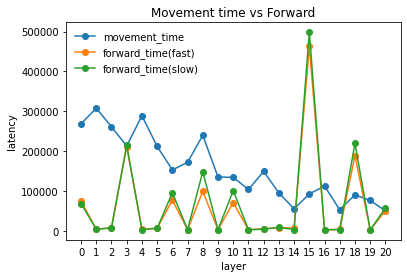

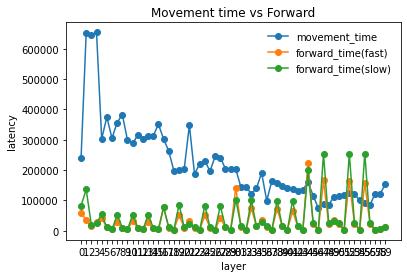

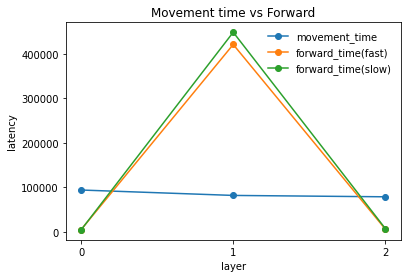

In [32]:
import matplotlib.pyplot as plt

def movement_time_forward(model):
    x = list(range(len(model.layer[1][fast])))

    plt.plot(x, model.movement[:-1], label='movement_time', marker='o')
    plt.plot(x, model.layer[1][fast], label='forward_time(fast)', marker='o')
    plt.plot(x, model.layer[1][slow], label='forward_time(slow)', marker='o')
    plt.title('Movement time vs Forward')
    plt.xlabel('layer')
    plt.ylabel('latency')
    plt.xticks(x)
    plt.legend(frameon=False)
    plt.show()
    
movement_time_forward(AlexNet)
movement_time_forward(ResNet)
movement_time_forward(RNN)

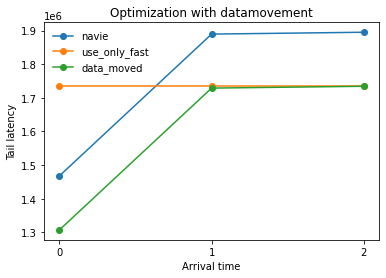

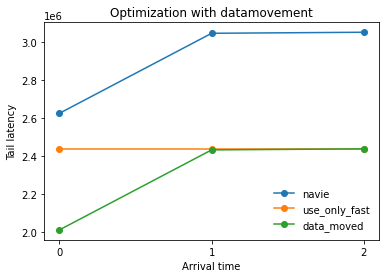

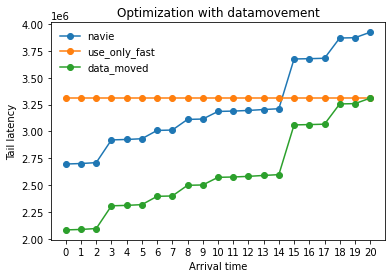

In [33]:
fast, slow = 1080, 2060
import matplotlib.pyplot as plt

def move_operation(Model_1, Model_2):
    delay = 0
    Model_1_slow = (sum(Model_1.layer[1][slow]))
    Model_1_fast = sum(Model_1.layer[1][fast])
    Model_2_slow = sum(Model_2.layer[1][slow])
    Model_2_fast = sum(Model_2.layer[1][fast])

    naive_data = list()
    use_only_fast_data = list()
    data_moved_data = list()
    delay_data = list()

    for index, value in enumerate(Model_2.layer[1][fast]):
        delay += value
        latency_fast = delay + Model_1_fast
        latency_slow = delay + Model_2.movement[index+1] + sum(Model_2.layer[1][slow][index+1:])

        tail_latency = max(latency_fast, latency_slow)
        naive = Model_1_slow + delay
        use_only_fast = Model_1_fast + Model_2_fast
        data_moved = tail_latency

        naive_data.append(naive)
        use_only_fast_data.append(use_only_fast)
        data_moved_data.append(data_moved)
        delay_data.append(delay)
        
    delay_data = list(range(len(delay_data)))

    plt.plot(delay_data, naive_data, label='navie', marker='o')
    plt.plot(delay_data, use_only_fast_data, label='use_only_fast', marker='o')
    plt.plot(delay_data, data_moved_data, label='data_moved', marker='o')
    plt.title('Optimization with datamovement')
    plt.xlabel('Arrival time')
    plt.ylabel('Tail latency')
    plt.xticks(delay_data)
    plt.legend(frameon=False)
    plt.show()

move_operation(AlexNet, RNN)
move_operation(ResNet, RNN)
move_operation(ResNet, AlexNet)

## Batching

In [34]:
import matplotlib.pyplot as plt
fast, slow = 1080, 2060

def batching_calculator(Model_1, Model_2):
    Model_1_slow = (sum(Model_1.layer[1][slow]))
    Model_1_fast = sum(Model_1.layer[1][fast])
    Model_2_slow = sum(Model_2.layer[1][slow])
    Model_2_fast = sum(Model_2.layer[1][fast])

    Model_1_2_slow = (sum(Model_1.layer[2][slow]))
    Model_1_2_fast = sum(Model_1.layer[2][fast])
    Model_2_2_slow = sum(Model_2.layer[2][slow])
    Model_2_2_fast = sum(Model_2.layer[2][fast])

    def batching(Model_1, Model_2, model_1_layer, model_2_layer):
        # Calculate naive policy
        model_1_end = sum(Model_1.layer[2][fast][model_1_layer:])
        model_2_end = sum(Model_2.layer[2][slow][model_2_layer:])
        if model_2_end < model_1_end:
            naive_latency = max((model_1_end, model_2_end + Model_1_slow))
        else:
            naive_latency = max((model_1_end + Model_1_fast, model_2_end))

        # Calculate best distribution
        best_distribution = min((max((model_1_end, model_2_end + Model_1_slow)), max((model_1_end + Model_1_fast, model_2_end))))

        # Batching without moving
        fast_end = sum(Model_1.layer[1][fast][:model_1_layer]) + sum(Model_1.layer[3][fast][model_1_layer:])
        batching_latency = max((model_2_end, fast_end))
        return best_distribution, batching_latency
    
    x = [list(), list(), list()]
    y = [list(), list(), list()]
    for i in range(len(Model_2.layer[1][fast])):
        row = list()
        for j in range(len(Model_1.layer[1][fast])):
            result = batching(Model_1, Model_2, j, i)
            x[result.index(min(result))].append(j)
            y[result.index(min(result))].append(i)

    plt.scatter(x[0], y[0], label='Navie')
    plt.scatter(x[1], y[1], label='Batching')
    plt.xticks(list(range(len(Model_1.layer[1][fast]))))
    plt.yticks(list(range(len(Model_2.layer[1][fast]))))
    plt.legend(frameon=False)
    plt.title('Decision with different layer pairs')
    plt.xlabel('Resnet layer')
    plt.ylabel('Alexnet layer')
    plt.show()

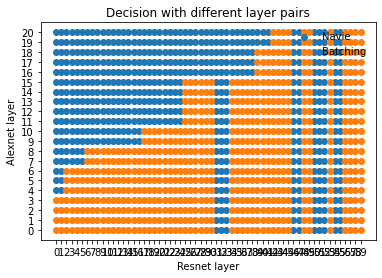

In [35]:
batching_calculator(ResNet, AlexNet)

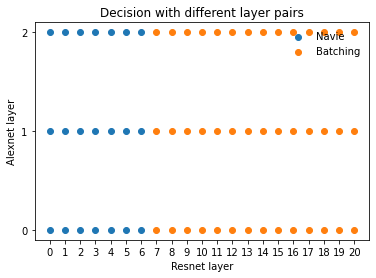

In [36]:
batching_calculator(AlexNet, RNN)

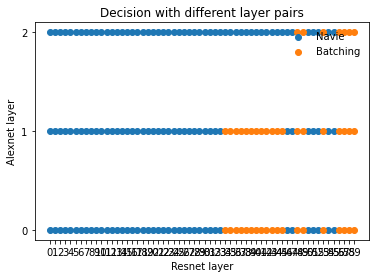

In [37]:
batching_calculator(ResNet, RNN)

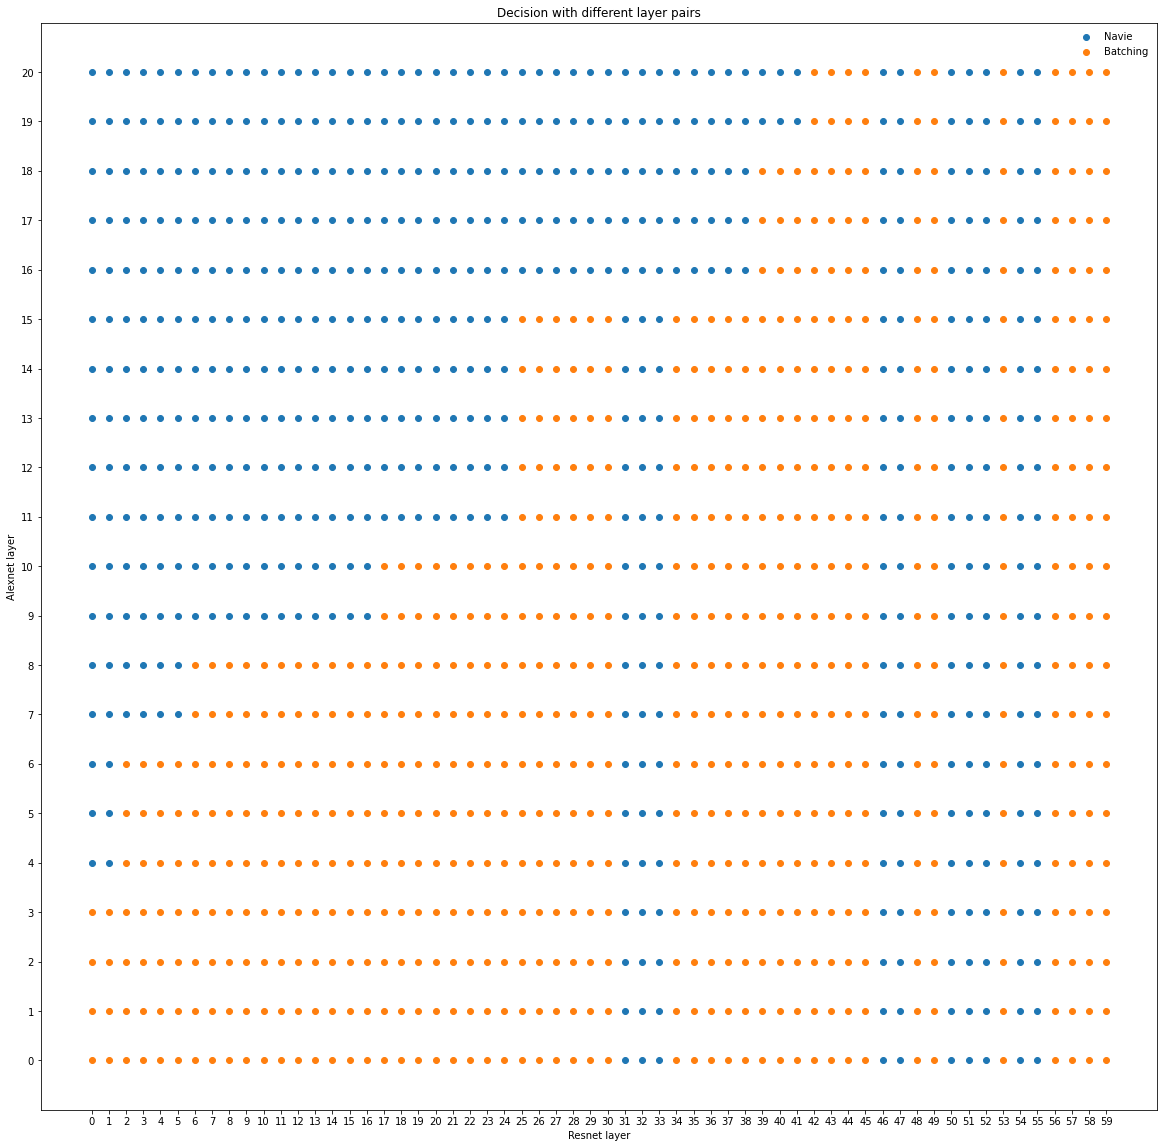

In [175]:
import matplotlib.pyplot as plt
x = [list(), list(), list()]
y = [list(), list(), list()]
for i in range(len(AlexNet[1][fast])):
    row = list()
    for j in range(len(ResNet[1][fast])):
        result = batching(i, j)
        x[result.index(min(result))].append(j)
        y[result.index(min(result))].append(i)

plt.scatter(x[0], y[0], label='Navie')
plt.scatter(x[1], y[1], label='Batching')
plt.xticks(list(range(len(ResNet[1][fast]))))
plt.yticks(list(range(len(AlexNet[1][fast]))))
plt.rcParams["figure.figsize"] = (20, 20)
plt.legend(frameon=False)
plt.title('Decision with different layer pairs')
plt.xlabel('Resnet layer')
plt.ylabel('Alexnet layer')
plt.show()

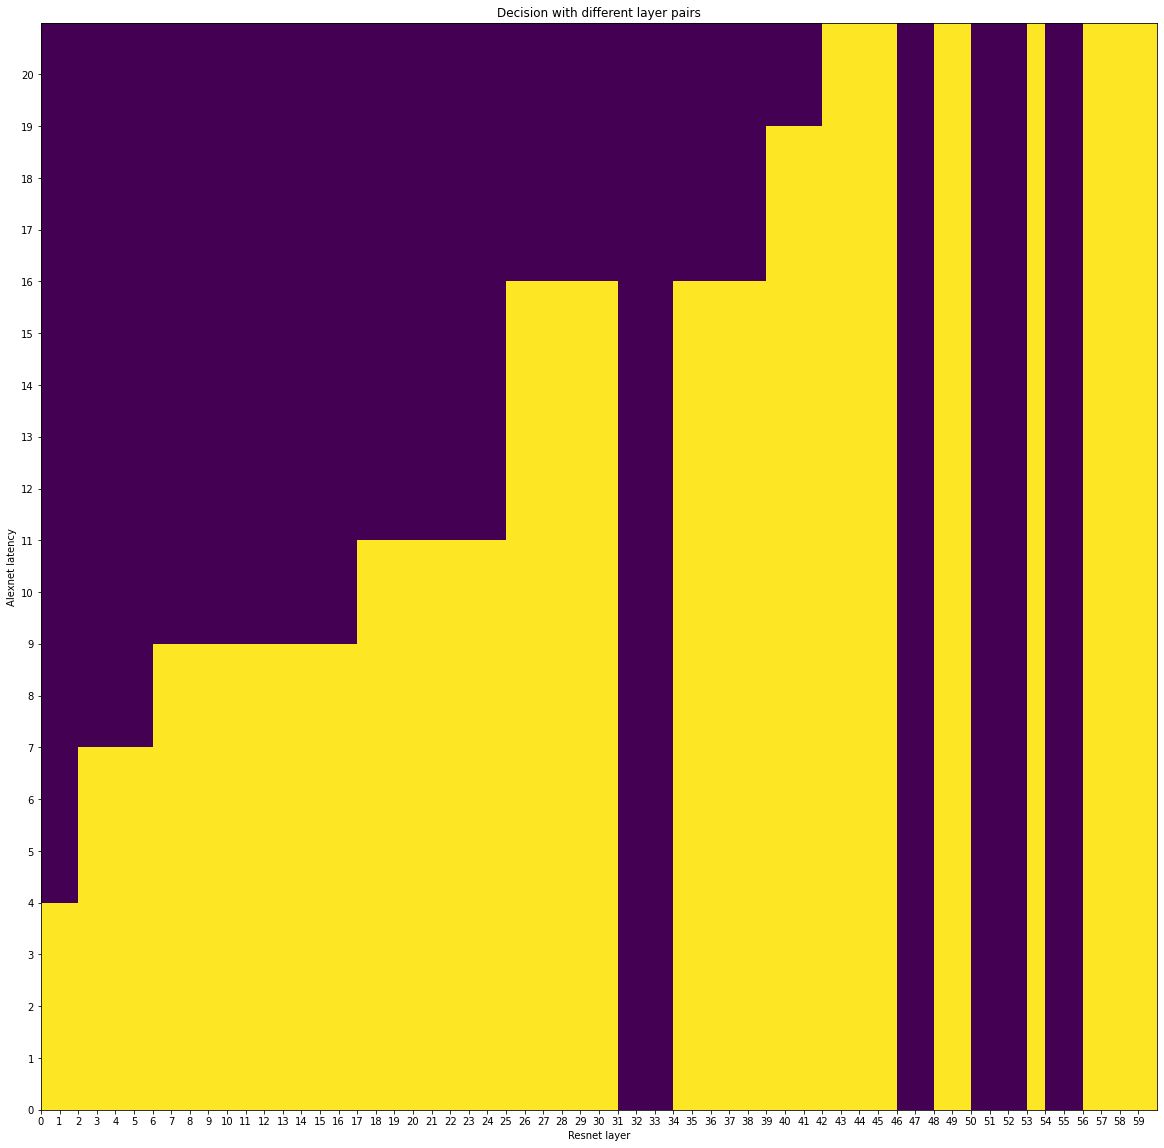

In [166]:
import matplotlib.pyplot as plt
data = list()
for i in range(len(AlexNet[1][fast])):
    row = list()
    for j in range(len(ResNet[1][fast])):
        result = batching(i, j)
        row.append(result.index(min(result)))
    data.append(row)
c = plt.pcolormesh(data)
plt.xticks(list(range(len(ResNet[1][fast]))))
plt.yticks(list(range(len(AlexNet[1][fast]))))
plt.rcParams["figure.figsize"] = (20,20)
plt.title('Decision with different layer pairs')
plt.xlabel('Resnet layer')
plt.ylabel('Alexnet latency')
plt.show()

In [10]:
fast, slow = 1080, 2060

delay = 0
ResNet_slow = (sum(ResNet[1][slow]))
ResNet_fast = sum(ResNet[1][fast])
AlexNet_slow = sum(AlexNet[1][slow])
AlexNet_fast = sum(AlexNet[1][fast])
RNN_slow = sum(RNN[1][slow])
RNN_fast = sum(RNN[1][fast])

naive_data = list()
use_only_fast_data = list()
data_moved_data = list()
delay_data = list()

for index, value in enumerate(AlexNet[1][fast]):
    delay += value
    latency_fast = delay + ResNet_fast
    latency_slow = delay + model_2_movement[index+1] + sum(AlexNet[1][slow][index+1:])
    
    tail_latency = max(latency_fast, latency_slow)
    naive = ResNet_slow + delay
    use_only_fast = ResNet_fast + AlexNet_fast
    data_moved = tail_latency
    
    naive_data.append(naive)
    use_only_fast_data.append(use_only_fast)
    data_moved_data.append(data_moved)
    delay_data.append(delay)

NameError: name 'movement_time' is not defined